In [3]:
import numpy as np
from tqdm import tqdm
import torch.nn as nn
import torch
import time
from SparsityAnalysis import extract_patterns, SparseConvArrays

### Load Actual Weights from Pattern-Pruned ResNet-34

In [2]:
path = 'resnet34_6_pattern_connectivity_pruning.pt'
state_dict = torch.load(path, map_location=torch.device('cpu'))

# residual_conv_dict = {k:v.cpu().numpy() for (k,v) in state_dict.items() if "layer" in k and "conv" in k}
residual_convs = [v.cpu().numpy() for (k, v) in state_dict.items() if "layer" in k and "conv" in k]
data_shapes = [
    [1, 64, 32, 32], [1, 64, 32, 32], [1, 64, 32, 32], [1, 64, 32, 32], [1, 64, 32, 32], [1, 64, 32, 32],
    [1, 64, 32, 32], [1, 128, 16, 16], [1, 128, 16, 16], [1, 128, 16, 16], [1, 128, 16, 16], [1, 128, 16, 16],
    [1, 128, 16, 16], [1, 128, 16, 16], [1, 128, 16, 16], [1, 256, 8, 8], [1, 256, 8, 8], [1, 256, 8, 8],
    [1, 256, 8, 8], [1, 256, 8, 8], [1, 256, 8, 8], [1, 256, 8, 8], [1, 256, 8, 8], [1, 256, 8, 8],
    [1, 256, 8, 8], [1, 256, 8, 8], [1, 256, 8, 8], [1, 512, 4, 4], [1, 512, 4, 4], [1, 512, 4, 4],
    [1, 512, 4, 4], [1, 512, 4, 4],
]

### Time Cost w/o memory transfer - nnpack

In [37]:
from conv_naive import Convolution
conv = Convolution()
cuda0 = torch.device('cuda:0')
cpu = torch.device('cpu')
total_time = 0
time_nnpack = []
repeat = 10


for idx in tqdm(range(len(residual_convs[:]))):
    input_data = np.ones(data_shapes[idx]).astype(np.float32)
    conv_mask = residual_convs[idx].astype(np.float32)
    input_data_g = torch.tensor(input_data, device = cuda0)
    conv_mask_g = torch.tensor(conv_mask, device = cuda0)
    cnt_total = 0
    for r in range(repeat):
        torch.cuda.synchronize()
        start = time.time()
        output_gt = nn.functional.conv2d(input_data_g, conv_mask_g,padding=1)
        #output_gt = nn.functional.conv2d(torch.tensor(input_data), torch.tensor(conv_mask),padding=1)
        torch.cuda.synchronize()
        end =  time.time()
        cnt_total += end - start

    total_time += cnt_total/repeat
    time_nnpack.append(cnt_total/repeat)

print(f'{round(total_time,3)}s')

100%|██████████| 32/32 [00:00<00:00, 237.12it/s]

0.009s


### Time Cost w/o memory transfer - normal conv

In [39]:
from conv_naive import Convolution
import numpy as np
from tqdm import tqdm
import time
conv = Convolution()
cuda0 = torch.device('cuda:0')
total_time = 0
time_normal_conv = []

for idx in tqdm(range(len(residual_convs[:]))):
    input_data = np.ones(data_shapes[idx]).astype(np.float32)
    conv_mask = residual_convs[idx].astype(np.float32)
    cnt_total = 0
    for r in range(repeat):
        output_1, time_= conv.conv_multiple_filters(input_data, conv_mask)
        cnt_total += time_
    total_time += cnt_total/repeat
    time_normal_conv.append(cnt_total/repeat)

print(f'{round(total_time,3)}s')


100%|██████████| 32/32 [00:00<00:00, 39.25it/s]

0.048s


### Time Cost w/o memory transfer - sparse conv 

In [45]:
from execution_time import SparseConvolution
from tqdm import tqdm


conv = SparseConvolution()

path = 'resnet34_6_pattern_connectivity_pruning.pt'
state_dict = torch.load(path, map_location=torch.device('cpu'))

residual_convs = [v.cpu().numpy() for (k, v) in state_dict.items() if "layer" in k and "conv" in k]
data_shapes = [
        [1, 64, 32, 32], [1, 64, 32, 32], [1, 64, 32, 32], [1, 64, 32, 32], [1, 64, 32, 32], [1, 64, 32, 32],
        [1, 64, 32, 32], [1, 128, 16, 16], [1, 128, 16, 16], [1, 128, 16, 16], [1, 128, 16, 16], [1, 128, 16, 16],
        [1, 128, 16, 16], [1, 128, 16, 16], [1, 128, 16, 16], [1, 256, 8, 8], [1, 256, 8, 8], [1, 256, 8, 8],
        [1, 256, 8, 8], [1, 256, 8, 8], [1, 256, 8, 8], [1, 256, 8, 8], [1, 256, 8, 8], [1, 256, 8, 8],
        [1, 256, 8, 8], [1, 256, 8, 8], [1, 256, 8, 8], [1, 512, 4, 4], [1, 512, 4, 4], [1, 512, 4, 4],
        [1, 512, 4, 4], [1, 512, 4, 4]]

time_sparse_naive = []
time_sparse_shared = []
time_sparse_constant = []

total_time_naive = 0
total_time_shared = 0
total_time_constant = 0


for i in tqdm(range(len(residual_convs[:]))):
    input_data = np.float32(np.ones(data_shapes[i]))

    if i == len(residual_convs) - 1:
        output_data =  np.float32(np.zeros(data_shapes[i]))
    else:
        output_data =  np.float32(np.zeros(data_shapes[i + 1]))

    conv_layer_weight = residual_convs[i].astype(np.float32)
    patterns = np.array(extract_patterns(conv_layer_weight))
    sparse_conv_arrays = SparseConvArrays(conv_layer_weight, patterns)
    offset = sparse_conv_arrays.offset
    reorder = sparse_conv_arrays.reorder
    index = sparse_conv_arrays.index
    stride = sparse_conv_arrays.stride
    sparse_weight = sparse_conv_arrays.weight
    ptset = np.float32(sparse_conv_arrays.ptset)

    # step 卷积步长
    if i == len(residual_convs) - 1:
        step = 1
    else:
        step = int(data_shapes[i][2] / data_shapes[i + 1][2])
    
    cnt_total_naive = 0; cnt_total_shared = 0
    for r in range(repeat):
        output_naive, time_without_mem_naive, time_include_mem_naive = conv.conv_sparse_naive(input_data, offset, reorder, index, stride, sparse_weight, ptset, step, output_data)
        output_shared, time_without_mem_shared, time_include_mem_shared = conv.conv_sparse_shared_mem(input_data, offset, reorder, index, stride, sparse_weight, ptset, step, output_data)
        cnt_total_naive += time_without_mem_naive
        cnt_total_shared += time_without_mem_shared


    time_sparse_naive.append(cnt_total_naive/repeat)
    time_sparse_shared.append(cnt_total_shared/repeat)
    
    total_time_naive += cnt_total_naive/repeat
    total_time_shared += cnt_total_shared/repeat
    

        #constant memory limit
    if sparse_weight.shape[0] <= 16384:
        cnt_total_constant= 0; 
        for r in range(repeat):
            output_constant, time_without_mem_constant,  time_include_mem_constant = conv.conv_sparse_shared_constant_mem(input_data, offset, reorder, index, stride, sparse_weight, ptset, step, output_data)
            cnt_total_constant += time_without_mem_constant
        time_sparse_constant.append(cnt_total_constant/repeat)
        total_time_constant += cnt_total_constant/repeat

print(f'naive: {round(total_time_naive,3)}s')
print(f'shared: {round(total_time_shared,3)}s')
print(f'constant: {round(total_time_constant,3)}s')


100%|██████████| 32/32 [00:23<00:00,  1.38it/s]

naive: 0.005s
shared: 0.005s
constant: 0.003s


### Time Cost w/o memory transfer - sparse conv - vs datasize

In [ ]:
from execution_time import SparseConvolution
from tqdm import tqdm


conv = SparseConvolution()

path = 'resnet34_6_pattern_connectivity_pruning.pt'
state_dict = torch.load(path, map_location=torch.device('cpu'))

residual_convs = [v.cpu().numpy() for (k, v) in state_dict.items() if "layer" in k and "conv" in k]
data_shapes = [[1, 64, 32, 32], [1, 64, 128, 128], [1, 64, 256, 256], [1, 64, 512, 512], [1, 64, 1024, 1024]]

time_without_mem_list_naive = []
time_include_mem_list_naive = []
time_without_mem_list_shared = []
time_include_mem_list_shared = []
time_without_mem_list_constant = []
time_include_mem_list_constant = []

time_wo_naive = 0
time_wo_shared = 0
time_wo_constant = 0

conv_layer_weight = residual_convs[i].astype(np.float32)
patterns = np.array(extract_patterns(conv_layer_weight))
sparse_conv_arrays = SparseConvArrays(conv_layer_weight, patterns)
offset = sparse_conv_arrays.offset
reorder = sparse_conv_arrays.reorder
index = sparse_conv_arrays.index
stride = sparse_conv_arrays.stride
sparse_weight = sparse_conv_arrays.weight
ptset = np.float32(sparse_conv_arrays.ptset)

for i in tqdm(range(len(data_shapes))):
    input_data = np.float32(np.ones(data_shapes[i]))

    if i == len(residual_convs) - 1:
        output_data =  np.float32(np.zeros(data_shapes[i]))
    else:
        output_data =  np.float32(np.zeros(data_shapes[i + 1]))

    conv_layer_weight = residual_convs[i].astype(np.float32)
    patterns = np.array(extract_patterns(conv_layer_weight))
    sparse_conv_arrays = SparseConvArrays(conv_layer_weight, patterns)
    offset = sparse_conv_arrays.offset
    reorder = sparse_conv_arrays.reorder
    index = sparse_conv_arrays.index
    stride = sparse_conv_arrays.stride
    sparse_weight = sparse_conv_arrays.weight
    ptset = np.float32(sparse_conv_arrays.ptset)

    # step 卷积步长
    if i == len(residual_convs) - 1:
        step = 1
    else:
        step = int(data_shapes[i][2] / data_shapes[i + 1][2])
        
    output_naive, time_without_mem_naive, time_include_mem_naive = conv.conv_sparse_naive(input_data, offset, reorder, index, stride, sparse_weight, ptset, step, output_data)
    output_shared, time_without_mem_shared, time_include_mem_shared = conv.conv_sparse_shared_mem(input_data, offset, reorder, index, stride, sparse_weight, ptset, step, output_data)

    time_without_mem_list_naive.append(time_without_mem_naive)
    time_include_mem_list_naive.append(time_include_mem_naive)
    time_without_mem_list_shared.append(time_without_mem_shared)
    time_include_mem_list_shared.append(time_include_mem_shared)
    
    time_wo_naive += time_without_mem_naive
    time_wo_shared += time_without_mem_shared
    

        #constant memory limit
    if sparse_weight.shape[0] <= 16384:
        output_constant, time_without_mem_constant,  time_include_mem_constant = conv.conv_sparse_shared_constant_mem(input_data, offset, reorder, index, stride, sparse_weight, ptset, step, output_data)
        time_without_mem_list_constant.append(time_without_mem_constant)
        time_include_mem_list_constant.append(time_include_mem_constant)



print(time_wo_naive)
print(time_wo_shared)
print(time_without_mem_list_naive)
print(time_without_mem_list_shared)

### Plot Generation

In [76]:
import matplotlib.pyplot as plt
time_nnpack = np.array(time_nnpack)
time_normal_conv = np.array(time_normal_conv)
time_sparse_naive = np.array(time_sparse_naive)
time_sparse_shared = np.array(time_sparse_shared)
time_sparse_constant = np.array(time_sparse_constant)

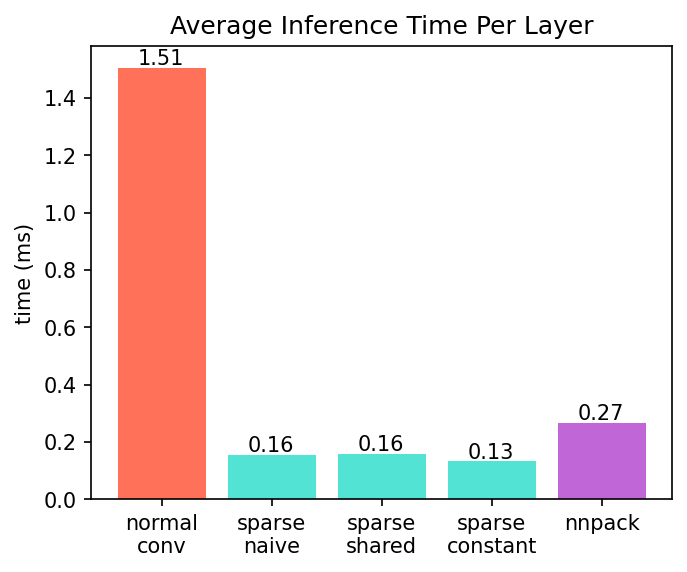

In [110]:
avg_nnpack = np.mean(time_nnpack)*1000
avg_normal = np.mean(time_normal_conv)*1000
avg_sparse_naive = np.mean(time_sparse_naive)*1000
avg_sparse_shared = np.mean(time_sparse_shared)*1000
avg_sparse_constant = np.mean(time_sparse_constant)*1000
labels = [ 'normal\nconv', 'sparse\nnaive', 'sparse\nshared', 'sparse\nconstant','nnpack']
data = [ avg_normal, avg_sparse_naive, avg_sparse_shared, avg_sparse_constant, avg_nnpack] 
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        plt.text(rect.get_x()+rect.get_width()/2-0.22, height + 0.01, '%.2f' % height)

plt.figure(figsize=(5, 4), dpi=150)
a = plt.bar(range(len(data)), data, tick_label=labels,color=['tomato','turquoise','turquoise', 'turquoise', 'mediumorchid'], alpha=0.9)
autolabel(a)
plt.title('Average Inference Time Per Layer')
plt.ylabel('time (ms)')
plt.savefig('Average Inference Time Per Layer.png')


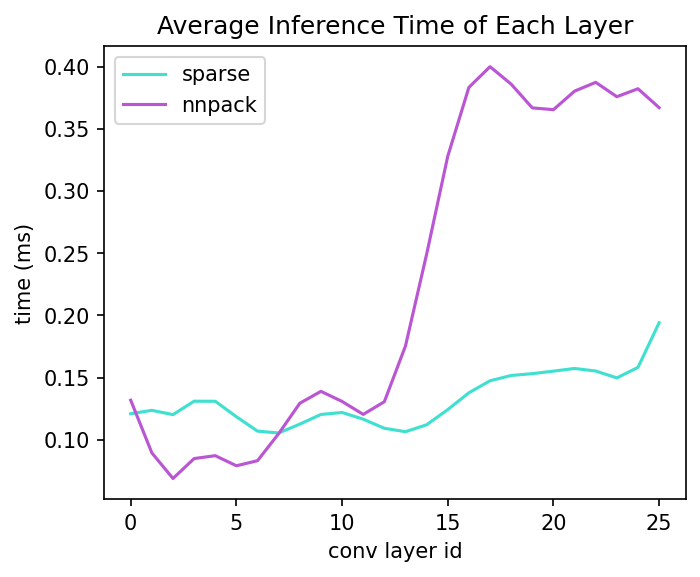

In [114]:
#plt.plot(time_normal_conv)
from numpy import polyfit, poly1d
plt.figure(figsize=(5, 4), dpi=150)
layer_id = [i for i in range(26)]
f_sparse_constant = poly1d(polyfit(layer_id,time_sparse_constant * 1000,12))
#f_sparse_naive = poly1d(polyfit(layer_id,time_sparse_naive[:26] * 1000,12))
f_nnpack = poly1d(polyfit(layer_id,time_nnpack[:26] * 1000,12))

#plt.plot(layer_id, f_sparse_naive(layer_id),label = 'naive', color = 'turquoise')
plt.plot(layer_id, f_sparse_constant(layer_id),label = 'sparse', color = 'turquoise')
plt.plot(layer_id, f_nnpack(layer_id), label = 'nnpack', color = 'mediumorchid')
plt.title('Average Inference Time of Each Layer')
plt.xlabel('conv layer id')
plt.ylabel('time (ms)')
plt.legend()
plt.savefig('Average Inference Time of Each Layer')